In [0]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt

from os import getcwd

model_path = getcwd()+"assg4model"

In [25]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
), batch_size=512, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data",
        train=False,
        download=True,
        transform=transforms.Compose(
            [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
), batch_size=512, shuffle=True)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1  = nn.Linear(784, 1024)  
        self.fc2 = nn.Linear(1024, 1024)  
        self.fc3 = nn.Linear(1024, 1024)  
        self.fc4 = nn.Linear(1024, 1024)  
        self.fc5 = nn.Linear(1024, 1024)  
        self.op = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.op(x))
        return x
    
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight.data)
        nn.init.zeros_(layer.bias.data)

activation = {}
def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()
    return hook

net = Net()
net.fc1.register_forward_hook(get_activation('fc1'))
net.fc2.register_forward_hook(get_activation('fc2'))
net.fc3.register_forward_hook(get_activation('fc3'))
net.fc4.register_forward_hook(get_activation('fc4'))
net.fc5.register_forward_hook(get_activation('fc5'))
net.apply(init_weights)
print(net)

learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (op): Linear(in_features=1024, out_features=10, bias=True)
)


In [26]:
# For sgd and adam
epoch_count = 10

accuracy_reached = False
total_epochs = 0
while not accuracy_reached:
    for epoch in range(epoch_count):
        running_loss = 0.0
        
        for index, data in enumerate(train_loader):
            inputs, labels = data
            
            # Flatten MNIST images into a 784 long vector
            inputs = inputs.view(inputs.shape[0], -1)

            optimizer.zero_grad() 

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if index % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.6f' %
                    (epoch + 1, index + 1, running_loss / 100))
                running_loss = 0.0

    print("Done training")
    total_epochs+=10

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.view(images.shape[0], -1)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} test images: {} %'.format(total, accuracy))

    if (accuracy>98 and total_epochs>30) or total_epochs>200:
        accuracy_reached = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 1.747522
[2,   100] loss: 1.587900
[3,   100] loss: 1.500602
[4,   100] loss: 1.487764
[5,   100] loss: 1.482387
[6,   100] loss: 1.478904
[7,   100] loss: 1.475183
[8,   100] loss: 1.473063
[9,   100] loss: 1.472350
[10,   100] loss: 1.470239
Done training
Accuracy of the network on the 10000 test images: 97.75 %
[1,   100] loss: 1.469224
[2,   100] loss: 1.468024
[3,   100] loss: 1.467977
[4,   100] loss: 1.468052
[5,   100] loss: 1.466765
[6,   100] loss: 1.466975
[7,   100] loss: 1.466975
[8,   100] loss: 1.467241
[9,   100] loss: 1.466819
[10,   100] loss: 1.468794
Done training
Accuracy of the network on the 10000 test images: 97.92 %
[1,   100] loss: 1.466471
[2,   100] loss: 1.466276
[3,   100] loss: 1.465158
[4,   100] loss: 1.465594
[5,   100] loss: 1.465445
[6,   100] loss: 1.465588
[7,   100] loss: 1.465370
[8,   100] loss: 1.465107
[9,   100] loss: 1.467677
[10,   100] loss: 1.466545
Done training
Accuracy of the network on the 10000 test images: 97.8 %
[1

Here, I have trained a network to reach the baseline 98% Accuracy

In [0]:

layer_list = ['fc1','fc2','fc3','fc4', 'fc5']
svd_over_layer_weights = []
bias_list_over_layers = []
for layer in layer_list:
    svd_over_layer_weights.append(
        torch.svd(getattr(net,layer).weight)
    )
    bias_list_over_layers.append(
        getattr(net,layer).bias
    )

d_range = [10, 20, 50, 100, 200]
w_bar_array = []

for d_val in d_range:
    w_bar_over_layers = []
    for svd_val in svd_over_layer_weights:
        w_bar_over_layers.append(
            torch.matmul(
                svd_val.U[:,:d_val], torch.matmul(
                    torch.diag(svd_val.S)[:d_val,:d_val], svd_val.V[:,:d_val].T
                )
            )
        )
    w_bar_array.append(w_bar_over_layers)

w_bar_over_layers = []
for svd_val in svd_over_layer_weights:
    w_bar_over_layers.append(
    torch.matmul(svd_val.U, torch.matmul(
            torch.diag(svd_val.S), svd_val.V.T
            )
        )
    )
w_bar_array.append(
    w_bar_over_layers
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images with D Value:10 is 25.72 %
Accuracy of the network on the 10000 test images with D Value:20 is 37.23 %
Accuracy of the network on the 10000 test images with D Value:50 is 60.46 %
Accuracy of the network on the 10000 test images with D Value:100 is 73.36 %
Accuracy of the network on the 10000 test images with D Value:200 is 91.74 %
Accuracy of the network on the 10000 test images with D Value:D_Full is 98.06 %


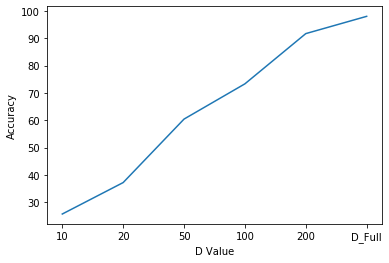

In [28]:
d_range += ['D_Full']

accuracy_over_d_parameter = []

for index, w_bar in enumerate(w_bar_array):
    correct = 0
    total = 0
    net2 = Net()


    net2.fc1.weight.data = w_bar[0]
    net2.fc2.weight.data = w_bar[1]
    net2.fc3.weight.data = w_bar[2]
    net2.fc4.weight.data = w_bar[3]
    net2.fc5.weight.data = w_bar[4]
    net2.fc1.bias.data = bias_list_over_layers[0]
    net2.fc2.bias.data = bias_list_over_layers[1]
    net2.fc3.bias.data = bias_list_over_layers[2]
    net2.fc4.bias.data = bias_list_over_layers[3]
    net2.fc5.bias.data = bias_list_over_layers[4]
    net2.op.weight = net.op.weight
    net2.op.bias = net.op.bias

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.view(images.shape[0], -1)
            outputs = net2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} test images with D Value:{} is {} %'.format(total, d_range[index], accuracy))
    accuracy_over_d_parameter.append(accuracy)

plt.plot(d_range, accuracy_over_d_parameter)
plt.xlabel('D Value')
plt.ylabel('Accuracy')
plt.show()


Here, I have initialized the networks with doing svd over the weights.

We can see that as we increase D, the network starts to perform better and better

In [0]:
class USVLayer(torch.nn.Module):
   
    def __init__(self, in_feat, out_feat, D_val):
        super(USVLayer, self).__init__()
        self.U_matrix = nn.Parameter(torch.Tensor(out_feat, in_feat)[:,:D_val])
        self.V_matrix = nn.Parameter(
            torch.Tensor(out_feat, in_feat)[:,:D_val]
        )
        self.bias = nn.Parameter(
            torch.Tensor(out_feat)
        )
    
    def forward(self, input):

        op1 = self.U_matrix.matmul(
            self.V_matrix
        )
        op2 = input.matmul(op1.T)
        return op2 + self.bias



Here, I have created my custom layer which has U and V_bar matrix as its parameters 

In [0]:
D_val = 20

class NetCool(nn.Module):

    def __init__(self):
        super(NetCool, self).__init__()
        self.fc1  = USVLayer(784, 1024, D_val)  
        self.fc2 = USVLayer(1024, 1024, D_val)  
        self.fc3 = USVLayer(1024, 1024, D_val)  
        self.fc4 = USVLayer(1024, 1024, D_val)  
        self.fc5 = USVLayer(1024, 1024, D_val)  
        self.op = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.op(x))
        return x


In [0]:
# For sgd and adam
netcool = NetCool()

for index, layer in enumerate(layer_list):
    obj = getattr(netcool, layer)
    obj.U_matrix.data = svd_over_layer_weights[index].U[:,:D_val]
    obj.V_matrix.data = torch.diag(
        svd_over_layer_weights[index].S)[:D_val,:D_val].matmul(
            svd_over_layer_weights[index].V[:,:D_val].T
        )
    obj.bias.data = bias_list_over_layers[index]

netcool.op.weight = net.op.weight
netcool.op.bias = net.op.bias

Here, I have created the network and initialized it with U and V matrix values with SVDed weights as was instructed

In [32]:
epoch_count = 10
learning_rate2 = 1e-4
optimizer2 = optim.Adam(net.parameters(), lr=learning_rate2)

accuracy_reached = False
total_epochs = 0

correct = 0
total = 0
accuracy_on_finetuning = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(images.shape[0], -1)
        outputs = netcool(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print('Accuracy of the network before finetuning on the {} test images: {} %'.format(total, accuracy))
accuracy_on_finetuning.append(accuracy)

while not accuracy_reached:
    for epoch in range(epoch_count):
        running_loss = 0.0
        
        for index, data in enumerate(train_loader):
            inputs, labels = data
            
            # Flatten MNIST images into a 784 long vector
            inputs = inputs.view(inputs.shape[0], -1)

            optimizer2.zero_grad() 

            outputs = netcool(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer2.step()
            
            running_loss += loss.item()
            if index % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.6f' %
                    (epoch + 1, index + 1, running_loss / 100))
                running_loss = 0.0
    print("Done training")
    total_epochs+=10

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.view(images.shape[0], -1)
            outputs = netcool(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the {} test images: {} %'.format(total, accuracy))
    if accuracy>90 or total_epochs == 200:
        accuracy_reached = True
    accuracy_on_finetuning.append(accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network before finetuning on the 10000 test images: 37.23 %
[1,   100] loss: 2.189584
[2,   100] loss: 2.144605
[3,   100] loss: 2.110760
[4,   100] loss: 2.085255
[5,   100] loss: 2.065560
[6,   100] loss: 2.049987
[7,   100] loss: 2.033940
[8,   100] loss: 2.020591
[9,   100] loss: 2.007369
[10,   100] loss: 1.995844
Done training
Accuracy of the network on the 10000 test images: 57.17 %
[1,   100] loss: 1.983570
[2,   100] loss: 1.973564
[3,   100] loss: 1.964003
[4,   100] loss: 1.957080
[5,   100] loss: 1.950364
[6,   100] loss: 1.943437
[7,   100] loss: 1.938834
[8,   100] loss: 1.931949
[9,   100] loss: 1.927877
[10,   100] loss: 1.923961
Done training
Accuracy of the network on the 10000 test images: 60.92 %
[1,   100] loss: 1.919088
[2,   100] loss: 1.915802
[3,   100] loss: 1.911286
[4,   100] loss: 1.908565
[5,   100] loss: 1.905027
[6,   100] loss: 1.902437
[7,   100] loss: 1.899695
[8,   100] loss: 1.896075
[9,   100] loss: 1.894922
[10,   100] loss: 1.8903

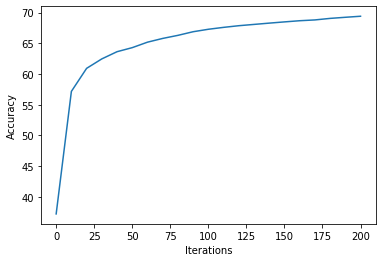

In [33]:
x_labels = [i*10 for i in range(len(accuracy_on_finetuning))]
plt.plot(x_labels, accuracy_on_finetuning)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

We can see in the above graph that, the network comppression works as expected and converges around 70% accuracy after 200 epochs using Adam optimizer